In [1]:
#Implementing RCNN from scratch using torch and torchvision libaries
#Importing the required libraries
import torch
import torchvision # for datasets and models
import torchvision.transforms as transforms # for transforms
import torch.nn as nn # for neural networks
import torch.nn.functional as F # for neural networks
import torch.optim as optim # for optimizers
import torchmetrics # for metrics
from torchmetrics.classification.accuracy import Accuracy # for accuracy
from torchvision.models import EfficientNet # for efficientnet backbone
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np

import random
import os # for os related operations
import urllib # for downloading the dataset
import tarfile # for extracting the dataset
import xml.etree.ElementTree as ET # for parsing the xml files for annotations
import pickle
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Defining hyper parameters beforehand
config={'image_size':224, 'n_classes':21, 'bbox_reg': True, 'network': 'efficientnet-b0', 'max_proposals':2000, 'pad': 16}
train_config={'log_wandb':True, 'logging': ['plot'],
            'epochs': 3, 'batch_size':128, 'lr': 0.001, 'lr_decay':0.5, 'l2_reg': 1e-5}
train_config_classifer={'log_wandb':True, 'logging': ['plot'],
            'epochs': 1, 'batch_size':128, 'lr': 0.001, 'lr_decay':0.5, 'l2_reg': 1e-5}
voc_2012_classes=['background','Aeroplane',"Bicycle",'Bird',"Boat","Bottle","Bus","Car","Cat","Chair",'Cow',"Dining table","Dog","Horse","Motorbike",'Person', "Potted plant",'Sheep',"Sofa","Train","TV/monitor"]

In [3]:
# Load Data
# Create Directory if it is not yet created
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [4]:
class VOCDataset():
    def __init__(self):
        self.train_dir = None
        self.test_dir = None
        self.trainDataLink = None
        self.testDataLink = None
        
        self.common_init()

    # init that must be shared among all subclasses of this method
    def common_init(self):
        self.label_type=['none','aeroplane',"Bicycle",'bird',"Boat","Bottle","Bus","Car","Cat","Chair",'cow',"Diningtable","Dog","Horse","Motorbike",'person', "Pottedplant",'sheep',"Sofa","Train","TVmonitor"]
        self.convert_id=['background','Aeroplane',"Bicycle",'Bird',"Boat","Bottle","Bus","Car","Cat","Chair",'Cow',"Dining table","Dog","Horse","Motorbike",'Person', "Potted plant",'Sheep',"Sofa","Train","TV/monitor"]
        self.convert_labels={}
        for idx, x in enumerate(self.label_type):
            self.convert_labels[x.lower()]=idx

        self.num_classes=len(self.label_type) # 20 + 1(none)
    
    # download the dataset
    def download_dataset(self,validation_size=5000):
        """
        Downloads the dataset and extracts it
        """
        #print("[@] Downloading dataset [@]") 
        #print(self.trainDataLink) # print the link 
        #urllib.request.urlretrieve(self.trainDataLink, 'voctrain.tar') # type: ignore # download the dataset

        #print("[@] Extracting dataset [@]")
        tar = tarfile.open("voctrain.tar","r:") # open the tar file
        tar.extractall('RCNN\\voctrain.tar') # extract the tar file
        tar.close() # close the tar file
        #os.remove('content/voctrain.rar') # remove the tar file

        if self.testDataLink is None: 
            # Move 5k images to validation state
            print("[@] Moving 5k images to validation state [@]")
            print(self.test_dir)
            ensure_dir(self.test_dir+'/Annotations/') # type: ignore # create the directory if it doesnt exist
            ensure_dir(self.test_dir+'/JPEGImages/') # type: ignore # create the directory if it doesnt exist

            random.seed(42) # set the seed
            print(len(os.listdir(self.train_dir+'/JPEGImages/'))) # print the number of images in the train directory
            val_images = random.sample(sorted(os.listdir(self.train_dir+'/JPEGImages/')),validation_size) # type: ignore # get the random images for validation set

            #for path in val_images:
             #   img_name = path.split('/')[-1].split('.')[0] # get the image name
                # move images
                #os.rename(self.train_dir+'/JPEGImages/'+img_name+'.jpg',self.test_dir+'/JPEGImages/'+img_name+'.jpg')  # type: ignore
                # move anotations
                #os.rename(self.train_dir+'/Annotations/'+img_name+'.xml',self.test_dir+'/Annotations/'+img_name+'.xml')  # type: ignore
        else:
            # Load the validation data
            print("[@] Downloading validation dataset [@]")
            urllib.request.urlretrieve(self.testDataLink, 'voctest.tar') # type: ignore # download the dataset

            print("[@] Extracting validation dataset [@]")
            tar = tarfile.open("voctest.tar","r:") # open the tar file
            tar.extractall('/content/VOCtest') # extract the tar file
            tar.close() # close the tar file
            os.remove('content/voctest.rar') # remove the tar file

    def read_xml(self,xml_path):
        """
        Read the xml file and return the data
        Args:
            xml_path: path to the xml file
        """
        object_list = [] 

        tree = ET.parse(open(xml_path,'r')) # parse the xml file
        root = tree.getroot() # get the root of the xml file

        objects = root.findall('object')
        for _object in objects:
            name = _object.find("name") # get the name of the object
            bndbox = _object.find("bndbox") # get the bounding box of the object
            # get the coordinates of the bounding box
            xmin = int(bndbox.find("xmin").text)  # type: ignore
            ymin = int(bndbox.find("ymin").text)  # type: ignore
            xmax = int(bndbox.find("xmax").text)  # type: ignore
            ymax = int(bndbox.find("ymax").text)  # type: ignore
            class_name = _object.find("name").text # get the class name of the object
            object_list.append({'x1':xmin, 'x2':xmax, 'y1':ymin, 'y2':ymax, 'class':self.convert_labels[class_name]}) # append the object to the list
        return object_list # return the list of objects



In [5]:
class VOC2007(VOCDataset):
    # Class for the VOC2007 dataset
    def __init__(self):
        self.train_dir = '/content/VOCtrain/VOCdevkit/VOC2007'
        self.test_dir = '/content/VOCtest/VOCdevkit/VOC2007'
        self.trainDataLink = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
        self.testDataLink = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar'
        self.common_init()

class VOC2012(VOCDataset):
    # Class for the VOC2012 dataset
    def __init__(self):
        self.train_dir = 'RCNN\\voctrain\VOCdevkit\VOC2012'
        self.test_dir = 'RCNN\\voctrain\VOCdevkit\VOC2012'
        self.trainDataLink = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
        self.testDataLink = None
        self.common_init()

In [6]:
voc_dataset=VOC2012() # create the dataset object
voc_dataset.download_dataset() # download the dataset

[@] Moving 5k images to validation state [@]
RCNN\voctrain\VOCdevkit\VOC2012
17125


In [7]:
val_datalen=len(os.listdir(voc_dataset.test_dir+'/Annotations'))
train_datalen=len(os.listdir(voc_dataset.train_dir+'/Annotations'))
print(train_datalen, val_datalen) # 17,125 total

17125 17125


In [8]:
def cv2_imshow(image,title="image"):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.show()

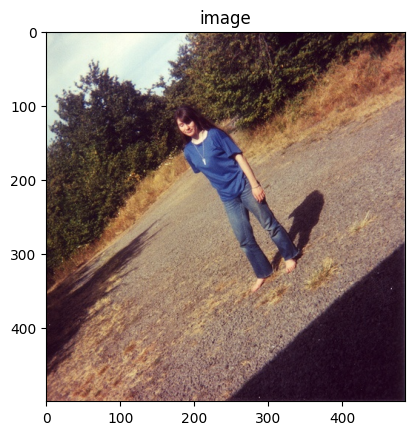

Shape: (500, 486, 3)


In [9]:

img_name = sorted(os.listdir(voc_dataset.train_dir+'/JPEGImages'))[0][:-4]

img=cv2.imread(voc_dataset.train_dir+'/JPEGImages/'+img_name+'.jpg')
cv2_imshow(img)
print('Shape:', img.shape)

w, h: 486 500


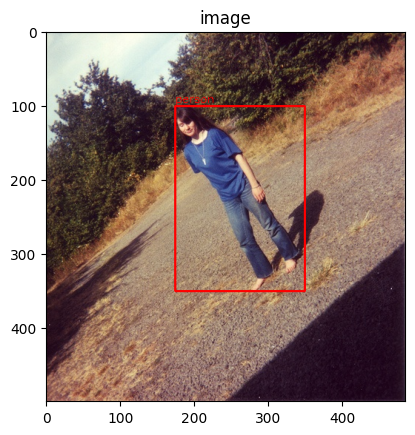

In [10]:
# referenced code of https://deepbaksuvision.github.io/Modu_ObjectDetection/posts/02_01_PASCAL_VOC.html
xml_path=voc_dataset.train_dir+'/Annotations/'+img_name+'.xml'
tree = ET.parse(open(xml_path, 'r'))

root=tree.getroot()
# print image shape
w, h = root.find("size").find("width").text, root.find("size").find("height").text
print('w, h:', w, h)

# plot bounding boxes
box_im=img.copy()
bbox_color=(0, 0, 255) # (b, g, r) not (r, g, b)
bbox_thickness=2

font                   = cv2.FONT_HERSHEY_SIMPLEX
fontScale              = 0.5
fontColor              = bbox_color
lineType               = 1


objects = root.findall("object")
for _object in objects:
  name = _object.find("name").text
  bndbox = _object.find("bndbox")
  xmin = int(bndbox.find("xmin").text)
  ymin = int(bndbox.find("ymin").text)
  xmax = int(bndbox.find("xmax").text)
  ymax = int(bndbox.find("ymax").text)
  class_name = _object.find('name').text

  cv2.rectangle(box_im, (xmin, ymin), (xmax, ymax), bbox_color, bbox_thickness)
  cv2.putText(box_im, class_name, (xmin, ymin-5), font, 
    fontScale,
    fontColor,
    lineType)

cv2_imshow(box_im)

Found 1263 boxes...


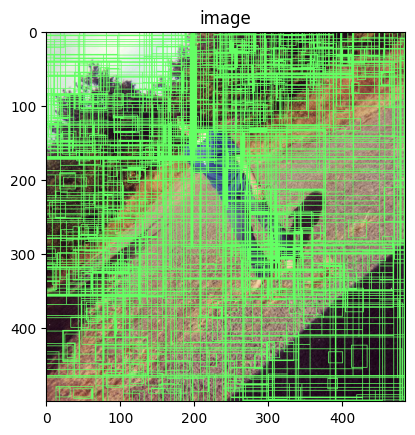

In [11]:
""" Demonstrating Selective Search Algorithm using opencv"""
img_ss=img.copy() # copy the image

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # create the selective search object
ss.setBaseImage(img_ss) # set the base image
ss.switchToSelectiveSearchFast() # "... extract around 2000 region proposals (we use selective search’s “fast mode” in all experiments)."
rects = ss.process()


print('Found',len(rects),'boxes...')
for i, rect in (enumerate(rects)):
    if i>2000:
        break
    x, y, w, h = rect
    cv2.rectangle(img_ss, (x, y), (x+w, y+h), (100, 255, 100), 1)
    
cv2_imshow(img_ss)

In [12]:
"""Helper functions for selective search and plotting results"""

def selective_search(image):
    """Perform selective search on the image and return the regions
    Parameters:
        image: the image to perform selective search on
    Returns:
        rects: the regions of interest
    """
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    return rects 

def plot_results(image, bboxes, color = (0,69,255)):
    """
    Plot the bounding boxes on the image
    Parameters:
        image: the image to plot on
        bboxes: the bounding boxes to plot
        color: the color of the bounding boxes
    
    Returns:
        image: the image with the bounding boxes plotted on it
    """
    plot_cfg = {
        'bbox_color': color, 'bbox_thickness': 2,
        'font': cv2.FONT_HERSHEY_SIMPLEX, 'font_scale': 0.5,
        'font_color': color, 'lineThickness': 1
    }
    img_ss = image.copy()
    for box in bboxes:
        bbox = box['bbox']
        cv2.rectangle(img_ss, (bbox['x1'], bbox['y1']), (bbox['x2'], bbox['y2']), plot_cfg['bbox_color'], plot_cfg['bbox_thickness'])
        cv2.putText(img_ss, f"{voc_dataset.label_type[box['class']]}, {str(box['conf'])[:5]}",  (bbox['x1'], bbox['y1'] - 5), plot_cfg['font'], 
                plot_cfg['fontScale'], plot_cfg['fontColor'], plot_cfg['lineThickness'])
    return img_ss

In [13]:
""" Helper function to calculate IoU"""

def calculate_IoU(bb1,bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    IoU == Area of Overlap / Area of Union
    Parameters
    ----------
    bb1 : dict
        Keys: 'x1', 'x2', 'y1', 'y2'
    bb2 : dict
        Keys: 'x1', 'x2', 'y1', 'y2'
    Returns
    -------
    float
        in [0, 1]
    """
    x_left = max(bb1['x1'], bb2['x1']) # max of left x-coord
    y_top = max(bb1['y1'], bb2['y1']) # max of top y-coord 
    x_right = min(bb1['x2'], bb2['x2']) # min of right x-coord
    y_bottom = min(bb1['y2'], bb2['y2']) # min of bottom y-coord

    # For no overlap, output should be 0
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # Calculate the overlap area
    intersection_area = (x_right - x_left) * (y_bottom - y_top) # Area of overlap/intersection
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1']) # area of bb1
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1']) # Area of bb2
    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    union_area = bb1_area + bb2_area - intersection_area # Union = Total Area - Overlap Area

    return intersection_area / union_area

In [14]:
""" Function to calculate mean average precision (mAP)"""
def mean_average_precision(pred, truth, iou_threshold=0.5, num_classes = 21, per_class = False):
    """
    Calculate the mean average precision (mAP) of the model predictions.

    Parameters
    ----------
    pred : list
        A list of dictionaries containing the model predictions.
    truth : list
        A list of dictionaries containing the ground truth bounding boxes.
    iou_threshold : float
        The threshold for the Intersection over Union (IoU) score.
    num_classes : int
        The number of classes in the dataset.
    per_class : bool
        Whether to calculate the mAP for each class.
    Returns
    -------
    float
        The mean average precision (mAP) of the model predictions.
    """
    # Calculate the average precision for each class
    average_precisions = []

    epsilon = 1e-6 # A small number to avoid division by zero   

    for c in range(num_classes):
        TP = 0
        FP = 0
        total_true_bboxes = 0

        # List detected(predicted) objects for class 'c'
        detections = []

        for idx, prs in enumerate(pred): # loop through all the predictions
            for pr in prs: # loop through all the predictions for a single image
                if pr['class'] == c: # if the prediction is for class 'c'
                    detections.append((pr['conf'],idx, pr['bbox'])) # (confidence, image_idx, bbox)
                    #detections.append({'conf': pr['conf'], 'idx': idx, 'bbox': pr['bbox']})
        total_true_bboxes = 0 # Total number of ground truth objects for class 'c'
        is_detected = [] # List of booleans indicating if a ground truth bbox has been detected
        for gts in pred: # Loop through ground truth objects
            is_detected.append([False for _ in gts]) # List of booleans for each ground truth bounding box
            total_true_bboxes += sum([gt['class']==c for gt in gts]) # Count the number of ground truth bounding boxes for class 'c'
        # Sort the detections by confidence score
        detections.sort(key=lambda x: x[0], reverse=True) # key = lambda x: x[0] is the same as key = itemgetter(0)

        TP = torch.zeros((len(detections))) 
        FP = torch.zeros((len(detections)))

        if total_true_bboxes == 0:
            continue 
        
        # Calculate the average precision 
        for detection_idx, detection in enumerate(detections):
            #Only take ground truths that have the same training index as the detection
            num_gts = len(truth[detection[1]])

            # find most closest ground truth box to pred as best_gt_index
            best_iou = 0
            best_gt_index = 0

            for idx, gt in enumerate(truth[detection[1]]): # for each ground truth box
                iou = calculate_IoU(gt,detection[2]) # calculate IoU
                if iou > best_iou: # if iou is better than previous best iou
                    best_iou = iou
                    best_gt_index = idx

            # If the IoU is higher than the threshold set this detection as true positive
            if best_iou > iou_threshold:
                # Only detect ground truth detection once
                if is_detected[detection[1]][best_gt_index] == False: # if ground truth box is not detected
                    # Set the flag to true
                    TP[detection_idx] = 1
                    is_detected[detection[1]][best_gt_index] = True
                else:
                    # Duplicate is FP
                    FP[detection_idx] = 1
            else:
                # If the IoU is lower than the threshold set this detection as false positive
                FP[detection_idx] = 1

        # Calculate the cumulative sum of the true positives and false positives
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)

        # Calculate the recall and precision
        recall = TP_cumsum / (total_true_bboxes + epsilon)
        precision = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        # Calculate the average precision
        precisions = torch.cat((torch.tensor([1]), precision))
        recalls = torch.cat((torch.tensor([0]), recall))
        average_precisions.append(torch.trapz(precisions, recalls))

        if per_class:
            return average_precisions
        else:
            return sum(average_precisions) / len(average_precisions)

In [15]:
"""Implementing Non-Max Suppression"""

def nms(p,iou_threshold=0.5):
    """
    Perform non-max suppression on the predictions.
    Parameters
    ----------
    p : list
        A list of dictionaries containing the model predictions.
        {'bbox': (x1, y1, x2, y2), 'class': class, 'conf': confidence}
    iou_threshold : float
        The threshold for the Intersection over Union (IoU) score.
    Returns 
    -------
    list
        A list of dictionaries containing the model predictions after performing non-max suppression.
    """
    conf_list = np.array([x['conf'] for x in p]) # List of confidence scores
    conf_order = (-conf_list).argsort() # Sort the predictions by confidence score in descending order
    isremoved = [False for _ in p] # List of booleans indicating if a prediction has been removed
    keep = []

    for idx in range(len(p)):
        to_keep = conf_order[idx]
        if isremoved[to_keep] == False:
            continue
        # Add the prediction with the highest confidence score to the list of predictions to keep
        keep.append(p[to_keep])
        isremoved[to_keep] = True

        # Removing overlapping boxes
        for order in range(idx+1, len(p)):
            bbox_idx = conf_order[order]
            if isremoved[bbox_idx] == False:
                # check overlap
                iou = calculate_IoU(p[to_keep]['bbox'],p[bbox_idx]['bbox'])
                if iou > iou_threshold:
                    isremoved[bbox_idx] = True
    return keep
                

In [16]:
# Domain specific fine-tuning the dataset
"""Implementing the dataset class"""
class RCNN_Dataset(torch.utils.data.Dataset):
    # Dataset class for the RCNN model
    def __init__(self, dataset, cfg, IOU_threshold={'positive':0.5, 'partial':0.3}, sample_ratio=(32,96),data_path='data'):
    
        """
        Parameters
        ----------
        dataset : list
            A list of dictionaries containing the dataset.
        cfg : dict
            A dictionary containing the configuration parameters.
        IOU_threshold : dict
            A dictionary containing the IOU thresholds for the positive and partial samples.
        sample_ratio : tuple
            A tuple containing the ratio of positive and partial samples.
        data_path : str
            The path to the data folder.
        """
        self.dataset = dataset
        self.cfg = cfg
        self.IOU_threshold = IOU_threshold
        self.sample_ratio = sample_ratio
        self.transform = transforms.Compose([transforms.Resize((cfg['image_size'], cfg['image_size'])), transforms.ToTensor(), transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])
        self.data_path = data_path

        if self.dataset_exists() == False:
            self.generate_dataset(sample_ratio, IOU_threshold)
        else:
            print("Loading Dataset")
            with open(self.data_path+'train_images.pkl', 'rb') as f:
                self.train_images = pickle.load(f)
            with open(self.data_path+'train_labels.pkl', 'rb') as f:
                self.train_labels = pickle.load(f)
            
            if not len(self.train_images) == len(self.train_labels):
                raise ValueError("The number of images and labels do not match")
            print("Dataset loaded")
    
    def __len__(self):
        return len(self.train_labels)
    
    def __getitem__(self,idx):
        """
        Parameters
        ----------
        idx : int
            The index of the sample to return.
        Returns
        -------
        tuple
            A tuple containing the image and the labels.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist() # Convert to list if tensor
            image = Image.fromarray(cv2.cvtColor(self.train_images[idx],cv2.COLOR_BGR2RGB)) # Convert to PIL image
            return {'image': self.transform(image), 'label': self.train_labels[idx][0], 'est_bbox': self.train_labels[idx][1], 'gt_bbox': self.train_labels[idx][2]}
    
    def dataset_exists(self):
        # Check if the dataset has been generated
        return os.path.exists(self.data_path+'train_images.pkl') and os.path.exists(self.data_path+'train_labels.pkl')
    
    def generate_dataset(self,sample_ratio, IoU_threshold, padding = 16):
        """
        Generate the dataset.
        Parameters
        ----------
        sample_ratio : tuple
            A tuple containing the ratio of positive and partial samples.
        IoU_threshold : dict
            A dictionary containing the IOU thresholds for the positive and partial samples.
        padding : int
            The padding to be added to the bounding box.
        """
        image_dir = self.dataset.train_dir + '/JPEGImages/'
        annot_dir = self.dataset.train_dir + '/Annotations/'
        obj_counter = 0
        bg_counter = 0
        self.train_images = [] # List of images
        self.train_labels = [] # List of labels

        print("Generating Dataset for RCNN")

        pbar = tqdm(sorted(os.listdir(image_dir))[:2000], position = 0, leave = True) # Progress bar

        for img_name in pbar:
            pbar.set_description(f"Data Size : {len(self.train_labels)}")
            image = cv2.imread(image_dir + img_name) # Read the image
            xml_path = annot_dir + img_name[:-4] + '.xml' # Get the path to the xml file
            gt_bboxes = self.dataset.read_xml(xml_path) # Get the ground truth bounding boxes
            rects = selective_search(image)[:2000] # Get the selective search regions of interest (ROI)
            random.shuffle(rects) # Shuffle the regions

            for x,y,w,h in rects: # Iterate through the regions
                x1,x2 = np.clip([x-padding, x+w+padding], 0, image.shape[1]) # Add padding to the bounding box
                y1,y2 = np.clip([y-padding, y+h+padding], 0, image.shape[0]) # Add padding to the bounding box
                bbox_est = {'x1':x1, 'x2':x2, 'y1':y1, 'y2':y2} # Estimated bounding box

                is_object = False # Flag to check if the region is an object
                for gt_bbox in gt_bboxes: # Iterate through the ground truth bounding boxes
                    iou = calculate_IoU(gt_bbox, bbox_est) # Calculate the IOU

                    if iou > IoU_threshold['positive']: # If the IOU is greater than the positive threshold
                        obj_counter += 1 # Increment the object counter
                        cropped = image[bbox_est['y1']:bbox_est['y2'], bbox_est['x1']:bbox_est['x2'], :] # Crop the image to the bounding box region  
                        self.train_images.append(cropped) # Append the cropped image to the list
                        est_bbox_xywh = ((bbox_est['x1'] + bbox_est['x2'])/2, (bbox_est['y1'] + bbox_est['y2'])/2,
                                        bbox_est['x2'] - bbox_est['x1'], bbox_est['y2'] - bbox_est['y1']) # Convert the bounding box to xywh format
                        gt_bbox_xywh = ((gt_bbox['x1'] + gt_bbox['x2'])/2, (gt_bbox['y1'] + gt_bbox['y2'])/2, 
                                        gt_bbox['x2'] - gt_bbox['x1'], gt_bbox['y2'] - gt_bbox['y1']) # Convert the bounding box to xywh format
                        self.train_labels.append([gt_bbox['class'], est_bbox_xywh, gt_bbox_xywh]) # Append the label to the list

                        is_object = True # Set the flag to true
                        break 
                    # if the object is not close to any gt box
                    if bg_counter < sample_ratio[1] and is_object == False: # If the region is not an object and the background counter is less than the partial sample ratio
                        bg_counter += 1 # Increment the background counter
                        cropped = image[bbox_est['y1']:bbox_est['y2'], bbox_est['x1']:bbox_est['x2'], :]  # Crop the image to the bounding box region
                        self.train_images.append(cropped) # Append the cropped image to the list
                        est_bbox_xywh = (1.0, 1.0, 1.0, 1.0) # Set the estimated bounding box to 1.0 (no object)
                        gt_bbox_xywh = (1.0, 1.0, 1.0, 1.0) # Set the ground truth bounding box to 1.0 (no object)
                        self.train_labels.append([0, est_bbox_xywh, gt_bbox_xywh]) # Append the label to the list
                    
                    if obj_counter >= sample_ratio[0] and bg_counter == sample_ratio[1]: # If the object counter is greater than the positive sample ratio and the background counter is greater than the partial sample ratio
                        obj_counter -= sample_ratio[0] # Decrement the object counter
                        bg_counter = 0 # Reset the background counter
                    
            print("Dataset Generated! Saving to", self.data_path)
            with open(self.data_path+'train_images.pkl', 'wb') as f:
                pickle.dump(self.train_images, f)
            with open(self.data_path+'train_labels.pkl', 'wb') as f:
                pickle.dump(self.train_labels, f)

In [17]:
def RCNN_DatasetLoader(voc_dataset, cfg, training_cfg, shuffle=True):
    """
    Create a dataset loader for the RCNN.
    Parameters
    ----------
    voc_dataset : VOC_Dataset
        The VOC dataset.
    cfg : dict
        The configuration dictionary.
    training_cfg : dict
        The training configuration dictionary.
    shuffle : bool
        Whether to shuffle the dataset.
    Returns
    -------
    dataset_loader : DataLoader
        The dataset loader.
    """
    ds = RCNN_Dataset(voc_dataset, cfg)
    return torch.utils.data.DataLoader(ds, batch_size=training_cfg['batch_size'], shuffle=shuffle, num_workers=2)

In [18]:
config={'image_size':224, 'n_classes':21, 'bbox_reg': True, 'network': 'efficientnet-b0', 'max_proposals':2000, 'pad': 16}
train_config={'log_wandb':True, 'logging': ['plot'],
            'epochs': 3, 'batch_size':128, 'lr': 0.001, 'lr_decay':0.5, 'l2_reg': 1e-5}
train_config_classifer={'log_wandb':True, 'logging': ['plot'],
            'epochs': 1, 'batch_size':128, 'lr': 0.001, 'lr_decay':0.5, 'l2_reg': 1e-5}

loader = RCNN_DatasetLoader(voc_dataset, config, train_config, shuffle=True)

Loading Dataset
Dataset loaded


In [19]:
print(type(loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [20]:
class RCNN_classifier_Dataset(torch.utils.data.Dataset):
    # https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    def __init__(self, dataset, cfg, IoU_threshold={'positive':0.5, 'partial':0.3}, sample_ratio=(32, 96),
                data_path='RCNN/content'):
        """
        Args:
        label_file (list of tuple(im path, label)): Path to image + annotations.
        im_root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.data_path = data_path # 
        self.dataset = dataset
        self.transform = transforms.Compose([ # preprocess image
            transforms.Resize((cfg['image_size'], cfg['image_size'])),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        if self.dataset_exists()==False:
            self.generate_dataset(sample_ratio, IoU_threshold)
        else: 
            print('[*] Loading dataset from', self.data_path)
            with open(self.data_path + 'train_images_classifier.pkl', 'rb') as f:
                self.train_images=pickle.load(f)
            with open(self.data_path + 'train_labels_classifier.pkl', 'rb') as f:
                self.train_labels=pickle.load(f)

        # check if both files are complete, flawless
            if not len(self.train_images)==len(self.train_labels):
                raise ValueError('The loaded dataset is invalid (of different size).')

    def __len__(self):
        return len(self.train_labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image=Image.fromarray(cv2.cvtColor(self.train_images[idx], cv2.COLOR_BGR2RGB))
        return  {'image': self.transform(image), 'label': self.train_labels[idx][0], 
                'est_bbox': self.train_labels[idx][1], 'gt_bbox': self.train_labels[idx][2]}
    '''
    # not working when interact too much w/ drive :(
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name = os.path.join(self.im_root_dir, self.label_file[idx][0])
    image = io.imread(img_name)
    if self.transform:
        image = self.transform(image)
    return  {'image': image, 'label': self.label_file[idx][1]}
    '''
    def dataset_exists(self):
        if os.path.exists(self.data_path+'train_images.pkl')==False:
            return False
        if os.path.exists(self.data_path + 'train_labels.pkl')==False:
            return False
    
        return True    

    def generate_dataset(self, sample_ratio, IoU_threshold, padding=16):
    #https://github.com/Hulkido/RCNN/blob/master/RCNN.ipynb

        image_dir=self.dataset.train_dir+'/JPEGImages/'
        annot_dir=self.dataset.train_dir+'/Annotations/'
        obj_counter = 0
        self.train_images=[]
        self.train_labels=[]

        print('[*] Generating dataset for R-CNN.')

        pbar = tqdm(sorted(os.listdir(image_dir)), position=0, leave=True) # only 2000 images :( <-------------
    
        for img_name in pbar:   
            pbar.set_description(f"Data size: {len(self.train_labels)}")

        # load image & gt bounding boxes 
        image = cv2.imread(image_dir + img_name)
        xml_path=annot_dir+img_name[:-4]+'.xml'
        gt_bboxes = self.dataset.read_xml(xml_path)

        # directly use gt bboxes as positive samples
        for gt_bbox in gt_bboxes:
            cropped = image[gt_bbox['y1']:gt_bbox['y2'], gt_bbox['x1']:gt_bbox['x2'], :]
            self.train_images.append(cropped)

            gt_bbox_xywh=((gt_bbox['x1'] + gt_bbox['x2']) / 2, (gt_bbox['y1'] + gt_bbox['y2']) / 2,
                            gt_bbox['x2']-gt_bbox['x1'], gt_bbox['y2']-gt_bbox['y1'])
            est_bbox_xywh = gt_bbox_xywh
            self.train_labels.append([gt_bbox['class'], est_bbox_xywh, gt_bbox_xywh])
        obj_counter += len(gt_bboxes)

        # time to collect background :)
        if obj_counter >= sample_ratio[0]:
            obj_counter -= sample_ratio[0]
        bg_counter = 0
        # generete bbox proposals via selective search
        rects = selective_search(image)[:2000]  # parse first 2000 boxes
        random.shuffle(rects)
        # loop through all ss bounding box proposals
        for (x, y, w, h) in rects:
            # apply padding
            x1, x2 = np.clip([x-padding, x+w+padding], 0, image.shape[1])
            y1, y2 = np.clip([y-padding, y+h+padding], 0, image.shape[0])
            bbox_est = {'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2}
            is_object = False

            # check the proposal with every elements of the gt boxes
            for gt_bbox in gt_bboxes:
                iou = calculate_IoU(gt_bbox, bbox_est)

                if iou > IoU_threshold['partial']: # if object
                    is_object=True
                break
            # save image
            if is_object==False:
                bg_counter+=1
            cropped = image[bbox_est['y1']:bbox_est['y2'], bbox_est['x1']:bbox_est['x2'], :]
            self.train_images.append(cropped)
            #cv2.imwrite(self.data_path+'train_images/'+str(image_count)+'.jpg', cropped) <-- too much drive I/O, timed out
            #image_count+=1
            est_bbox_xywh=(1.0, 1.0, 1.0, 1.0)
            gt_bbox_xywh=(1.0, 1.0, 1.0, 1.0)
            self.train_labels.append([0, est_bbox_xywh, gt_bbox_xywh])

            if bg_counter==sample_ratio[1]:  # control the ratio between 2 types
                break

        
        print('[*] Dataset generated! Saving labels to', self.data_path)
        with open(self.data_path + 'train_labels_classifier.pkl', 'wb') as f:
            pickle.dump(self.train_labels, f)
        with open(self.data_path + 'train_labels_classifier.pkl', 'wb') as f:
            pickle.dump(self.train_images, f)

In [21]:
def RCNN_classifier_DatasetLoader(voc_dataset, cfg, training_cfg, shuffle=True):
  ds = RCNN_classifier_Dataset(voc_dataset, cfg)
  return torch.utils.data.DataLoader(ds, batch_size=training_cfg['batch_size'], shuffle=shuffle, num_workers=2)

In [22]:
classifier_dataloader=RCNN_classifier_DatasetLoader(voc_dataset, config, train_config)    # `loader` is an instance of RCNN_dataset

[*] Generating dataset for R-CNN.


Data size: 0: 100%|██████████| 17125/17125 [00:11<00:00, 1517.28it/s]


[*] Dataset generated! Saving labels to RCNN/content


In [23]:
"""invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1., 1., 1. ]), 
                                transforms.ToPILImage() ])

for x in classifier_dataloader:
  for idx in range(20):
    plt.imshow(invTrans(x['image'][idx]))
    plt.show()
    print(voc_2012_classes[x['label'][idx]])
  break"""

"invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),\n                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1., 1., 1. ]), \n                                transforms.ToPILImage() ])\n\nfor x in classifier_dataloader:\n  for idx in range(20):\n    plt.imshow(invTrans(x['image'][idx]))\n    plt.show()\n    print(voc_2012_classes[x['label'][idx]])\n  break"

In [24]:
"""invTrans = transforms.Compose([
    transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]), # 1/std to normalize back to original image values (0-255) 
    transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.]), # -mean to normalize back to original image values (0-255)
    #transforms.ToPILImage() # convert back to PIL image from torch tensors 
])

for x in classifier_dataloader:
    for idx in range(20):
        plt.imshow(invTrans(x['image'][idx]))
        plt.show()
        print(voc_2012_classes[x['label'][idx]])
    break"""

"invTrans = transforms.Compose([\n    transforms.Normalize(mean = [0., 0., 0.], std = [1/0.229, 1/0.224, 1/0.225]), # 1/std to normalize back to original image values (0-255) \n    transforms.Normalize(mean = [-0.485, -0.456, -0.406], std = [1., 1., 1.]), # -mean to normalize back to original image values (0-255)\n    #transforms.ToPILImage() # convert back to PIL image from torch tensors \n])\n\nfor x in classifier_dataloader:\n    for idx in range(20):\n        plt.imshow(invTrans(x['image'][idx]))\n        plt.show()\n        print(voc_2012_classes[x['label'][idx]])\n    break"

In [ ]:
## Creating the RCNN model

def RCNN(cfg, load_path=None):
    if load_path:
        try:
            print("Attempting to load the model from: ",load_path) 
            loaded = torch.load(load_path) # load the model from the path
            print("Model loaded successfully!")
        except:
            print("Model could not be loaded! Creating a new model instead.")
            return _RCNN(cfg)


            #Check if loaded is an rcnn instance
        if loaded.__class__.__name__ == "RCNN":
            print("Model loaded successfully!")
            return loaded
        else:
            raise ValueError("the loaded tensor is not an instance of _RCNN") # if it is not an instance of RCNN, raise an error
    else:
        print("Creating Model")
        return _RCNN(cfg)

class _RCNN(nn.Module):
    def __init__(self, cfg):
        super(_RCNN, self).__init__() # initialize the nn.Module class
        self.num_classes = cfg['n_classes'] # 20
        self.dobbox_reg = cfg['bbox_reg'] # boolean to indicate whether to do bbox regression or not
        self.max_proposals = cfg['max_proposals'] # max number of proposals to be generated by selective search
        self.image_size = cfg['image_size'] # efficient-net-b0: 224

        if cfg['network'] == 'efficientnet-b0':
            self.initialize_weights()
    
    def inference(self, images, rgb = False, batch_size = 128, apply_nms = True, nms_threshold = 0.2): 
        """
        This function is used to perform inference on the model. It takes in a batch of images and returns the predicted bounding boxes and classes for each image.
        
        Parameters:
        -----------
        images: list of PIL images
        rgb: boolean to indicate whether the images are in RGB format or not
        batch_size: batch size to use for inference
        apply_nms: boolean to indicate whether to apply non-max suppression or not
        nms_threshold: threshold to use for non-max suppression
        
        Returns:
        --------
        bboxes: list of bounding boxes for each image
        classes: list of classes for each image
        """
        # if a single image is given
        if type(images) == np.ndarray and len(images.shape) == 3:
            return self.inference_single(images, rgb, batch_size, apply_nms) # call the inference_single function
        
        bboxes = []
        for image in tqdm(images, position=0):
            pred_bboxes = self.inference_single(image, rgb, batch_size, apply_nms, silent_mode=True)
            bboxes.append(pred_bboxes)
        return bboxes

    def inference_single(self, image, rgb=False, batch_size=128,apply_nms=True, nms_threshold=0.2, silent_mode=False):
        """
        This function is used to perform inference on the model. It takes in a single image and returns the predicted bounding boxes and classes for that image.
        
        Parameters:
        -----------
        image: PIL image
        rgb: boolean to indicate whether the images are in RGB format or not
        batch_size: batch size to use for inference
        apply_nms: boolean to indicate whether to apply non-max suppression or not
        nms_threshold: threshold to use for non-max suppression
        
        Returns:
        --------
        bboxes: list of bounding boxes for each image
        classes: list of classes for each image
        """
        if not silent_mode:
            print("Performing inference on the model")
        if not rgb:
            image = image.convert('RGB')    # convert the image to RGB format
        image = image.resize((self.image_size, self.image_size)) # resize the image to the input size of the model
        image = np.array(image) # convert the image to a numpy array
        image = image.astype(np.float32) # convert the image to float32     
        image = image / 255.0 # normalize the image
        image = image.transpose(2, 0, 1) # transpose the image to (C, H, W)
        image = torch.from_numpy(image) # convert the image to a torch tensor
        image = image.unsqueeze(0) # add a batch dimension to the image
        image = image.to(device) # move the image to the device
        with torch.no_grad(): # disable gradient calculation
            pred_bboxes, pred_classes = self(image) # perform inference on the model
        pred_bboxes = pred_bboxes.squeeze(0) # remove the batch dimension
        pred_classes = pred_classes.squeeze(0) # remove the batch dimension
        
